In [6]:

import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time

def display_image(image):
    fig, axes = plt.subplots(figsize=(12, 8))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.show()

def display_image_pair(first_image, second_image):
    #this funciton from Computer vision course notes 
    # When using plt.subplots, we can specify how many plottable regions we want to create through nrows and ncols
    # Here we are creating a subplot with 2 columns and 1 row (i.e. side-by-side axes)
    # When we do this, axes becomes a list of length 2 (Containing both plottable axes)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    # TODO: Call imshow on each of the axes with the first and second images
    #       Make sure you handle both RGB and grayscale images
    if first_image.ndim == 2:
        axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(cv2.cvtColor(second_image, cv2.COLOR_BGR2RGB))

    plt.show()

0.0057489871978759766


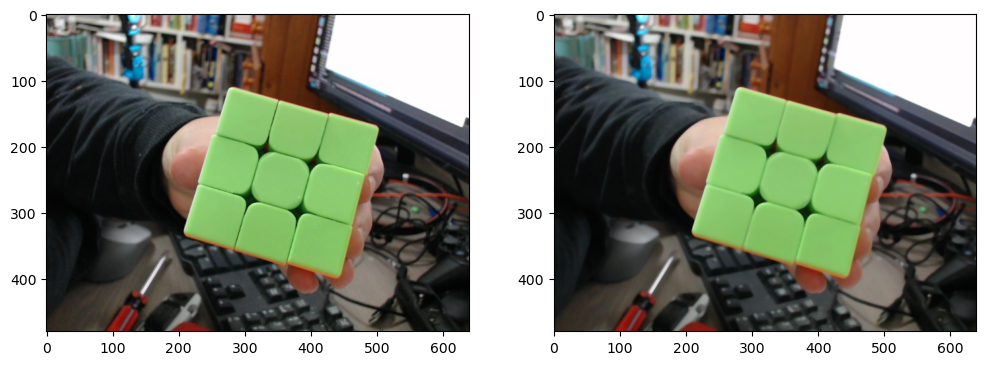

In [7]:
# Read the grayscale image
image = cv2.imread('./image_out/cubepic_0.jpg')
t1 = time.time()
#use a median filter to get rid of the noise
filtered_image = np.zeros_like(image)
for i in range(3):  # Assuming the image has 3 channels (BGR)
    filtered_image[:, :, i] = cv2.medianBlur(image[:, :, i], 5)
# filtered_image = cv2.medianBlur(image, 5) 
t2 = time.time()

print(t2-t1)

display_image_pair(image, filtered_image)

Time taken for K-means clustering: 354.6453478336334 seconds


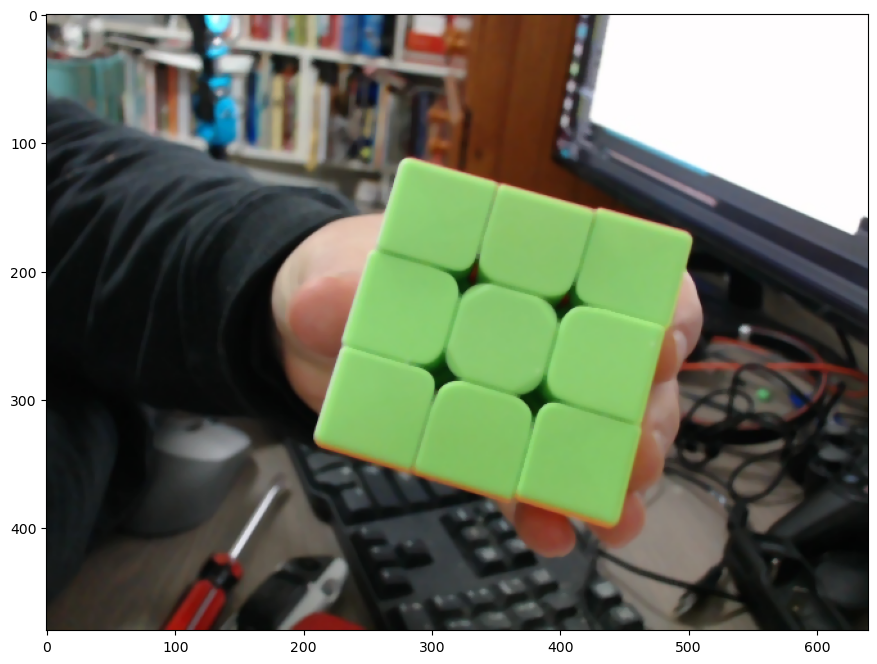

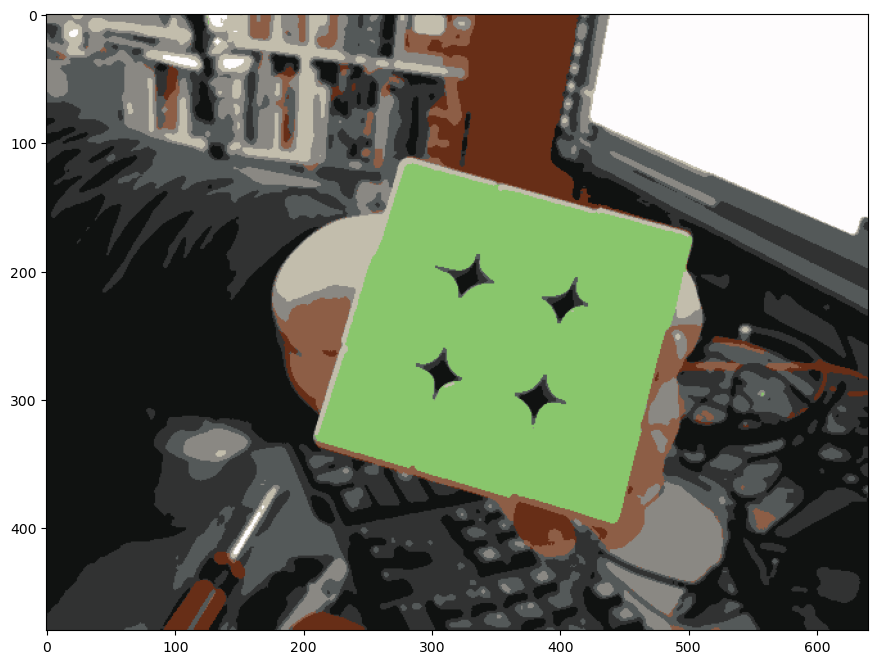

In [11]:
# from sklearn.cluster import MeanShift, estimate_bandwidth
pixels = filtered_image.reshape(-1, 3)

# Define the size of the random sample
sample_size = 10000

# Take a random sample from the pixels array
np.random.seed(42)
random_sample_indices = np.random.choice(pixels.shape[0], sample_size, replace=False)
random_sample = pixels[random_sample_indices]


# Perform K-means clustering
k = 9  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(random_sample)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_
clusters = kmeans.predict(pixels)

# Reshape the clustered pixels to form the image
clustered_image = cluster_centers[clusters].reshape(filtered_image.shape)

# Convert the image to 8-bit for visualization
clustered_image = np.uint8(clustered_image)

t2 = time.time()
print(f"Time taken for K-means clustering: {t2-t1} seconds")

# Display the original and clustered images
display_image(filtered_image)
display_image(clustered_image)


Time taken for segmentation: 1236.4853177070618 seconds


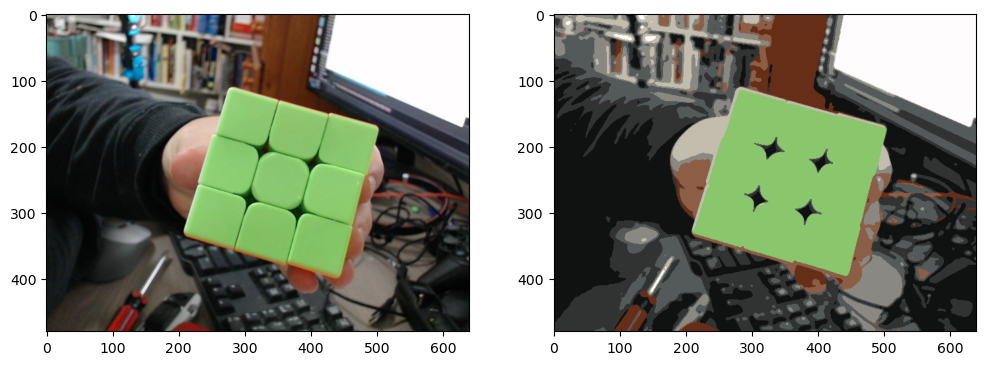

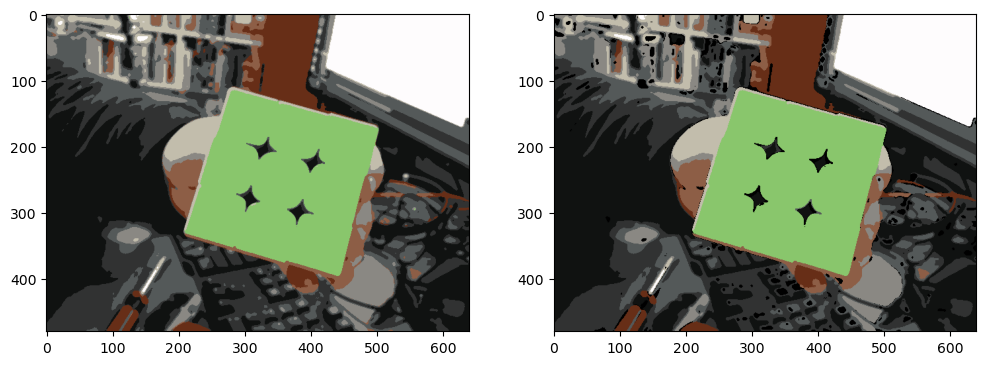

In [18]:
gray_level_ranges = [(np.array(center) - 3, np.array(center) + 3) for center in cluster_centers]

segmentation_masks = np.zeros_like(clustered_image, dtype=np.uint8)

num_labels = []
labels = []
stats = []

# Iterate over each region and create a segmentation mask
for i, (min_level, max_level) in enumerate(gray_level_ranges):
    # Apply thresholding to create a binary image for the current region
    binary_image = cv2.inRange(clustered_image, min_level, max_level)

    # Apply connected component labeling
    num_labels_, labels_, stats_, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    
    # Process each connected component
    for p, st in enumerate(stats_):
        if p == 0:
            continue
        if st[cv2.CC_STAT_AREA] < 100:
            segmentation_masks[labels_ == p] = 0
        else:
            segmentation_masks[labels_ == p] = cluster_centers[i]

    num_labels.append(num_labels_)
    labels.append(labels_)
    stats.extend(stats_)

t2 = time.time()
print(f"Time taken for segmentation: {t2 - t1} seconds")

# Convert the segmented image to 8-bit for visualization
segmentation_masks = np.uint8(segmentation_masks)

# Display the original, clustered, and segmented images
display_image_pair(image, clustered_image)#, title1="Original Image", title2="Clustered Image")
display_image_pair(clustered_image, segmentation_masks)#, title1="Clustered Image", title2="Segmented Image")



In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import sys
# Initialize the YOLOv8 model
model = YOLO('yolov8s.pt')  # Make sure to provide the correct path to your YOLOv8 model file

# Open a connection to the webcam (0 is the default camera)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video device.")
    sys.exit(1)

# Set camera properties (optional)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    # Perform inference on the frame
    results = model(frame)

    # Process the results
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Extract box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            cls = int(box.cls[0])

            # Draw the bounding box and label on the frame
            label = f"{model.names[cls]} {conf:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('YOLOv8 Detection', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture and close windows
cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 64.6ms
Speed: 2.0ms preprocess, 64.6ms inference, 14.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 4.2ms
Speed: 1.7ms preprocess, 4.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.7ms
Speed: 1.3ms preprocess, 3.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.9ms
Speed: 1.9ms preprocess, 3.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.7ms
Speed: 0.9ms preprocess, 3.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 4.1ms
Speed: 1.7ms preprocess, 4.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 4.2ms
Speed: 1.0ms preprocess, 4.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 4.2ms
Speed: 1.1ms preprocess, 4.2ms inference, 0.4

0.2306218147277832


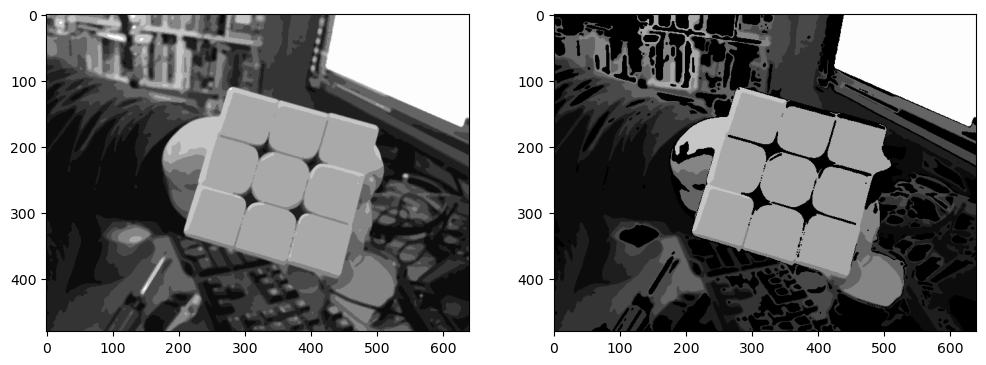

In [4]:


t1 = time.time()
gray_level_ranges = [(*i-1, *i+1) for i in cluster_centers]
segmentation_masks = np.zeros_like(clustered_image, dtype=np.uint8)
q = 1
qq=1
num_labels=[]
labels = []
stats = []
seg_masks = []
# Iterate over each region and create a segmentation mask
for i, (min_level, max_level) in enumerate(gray_level_ranges):
    # Apply thresholding to create a binary image for the current region
    _, binary_image = cv2.threshold(clustered_image, min_level, 255, cv2.THRESH_BINARY)
    _, upper_thresholded = cv2.threshold(clustered_image, max_level, 255, cv2.THRESH_BINARY_INV)
    binary_image = cv2.bitwise_and(binary_image, upper_thresholded)

    # Apply connected component labeling
    # t1 = time.time()
    num_labels_, labels_, stats_, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    # t2 = time.time()
    # print(t2-t1)
    # for s in stats_:
    #     stats.append(s)
    num_labels.append(num_labels_)
    labels.append(labels_)
    
    # Assign a unique label to the corresponding pixels in the segmentation masks
    p = 1
    for p, st in enumerate(stats_):# range(q, q+num_labels_-1):
        if p==0:
            continue        
        elif st[cv2.CC_STAT_AREA] < 1000:
            segmentation_masks[labels_ == p] = 0
            #color[labels_ == p] = color[labels_ == p]
        else:
            stats.append(st)
            segmentation_masks[labels_ == p] =cluster_centers[i]
            
        p+=1
    # break
t2 = time.time()

print(t2-t1)
display_image_pair(clustered_image,segmentation_masks)
